In [16]:
import pandas as pd
data = pd.read_csv("fragrantica_cleaned_with_description.csv", sep=';', encoding='ISO-8859-1')

# Huggingface에서 가져온 MiniLM 트랜스포머 사용




In [2]:
!pip install faiss-cpu

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.5/27.5 MB 74.3 MB/s eta 0:00:00


In [17]:
from sentence_transformers import SentenceTransformer
import numpy as np
import faiss
import json

#vectorization
def vectorize(data):
  # Sentence-BERT 모델 로드
  model = SentenceTransformer('all-MiniLM-L6-v2')
  # 임베딩 생성
  embeddings = model.encode(data['description'].tolist())
  embeddings = np.array(embeddings)

  return embeddings

#save embeddings
def save_embeddings(embeddings, data):
  # FAISS 인덱스 생성
  dimension = embeddings.shape[1]
  index = faiss.IndexFlatL2(dimension)  # L2 distance 기반 인덱스
  index.add(embeddings)  # 임베딩 추가

  # 인덱스 저장
  faiss.write_index(index, "./res/embeddings_index.faiss")

  print("Embeddings 저장 완료!")

  metadata = data.to_dict(orient='records')

  # JSON 파일로 저장
  with open('./res/metadata.json', 'w') as f:
      json.dump({"embeddings": embeddings.tolist(), "metadata": metadata}, f)
  print("Metadata 저장 완료!")

  return

#load embeddings
def load_embeddings():
  # FAISS 인덱스 및 메타데이터 로드
  index = faiss.read_index("./res/embeddings_index.faiss")
  with open("./res/metadata.json", "r") as f:
      data = json.load(f)
  metadata = data["metadata"]

  return index, metadata

#search perfume
def search_perfume(index, metadata):
  # SentenceTransformer 모델 로드
  model = SentenceTransformer('all-MiniLM-L6-v2')

  # 사용자 입력 받기
  user_query = input("Enter your query: ")

  # 사용자 입력 문장을 임베딩으로 변환
  query_embedding = model.encode(user_query).reshape(1, -1)

  # 상위 3개의 결과 검색
  k = 3
  distances, indices = index.search(query_embedding, k)

  # 검색된 결과 출력
  results = []
  for idx, distance in zip(indices[0], distances[0]):
      result = metadata[idx]
      results.append({
          "description": result['description'],
          "distance": distance,
          "url": result['url']
      })

  # 결과 출력
  for i, result in enumerate(results):
      print(f"\nResult {i + 1}:")
      print(f"Description: {result['description']}")
      print(f"Similarity Score: {1 - result['distance']:.2f}")
      print(f"More information: {result['url']}")

  return results


'\nfrom sklearn.metrics.pairwise import cosine_similarity\nsimilarity = cosine_similarity(embeddings)\nsimilarity\n'

In [19]:
embeddings = vectorize(data)
save_embeddings(embeddings, data)

Embeddings 저장 완료!
Metadata 저장 완료!


In [24]:
index, metadata = load_embeddings()

Enter your query: tom ford perfume

Result 1:
Description: Tom ford for men by Tom ford is a men fragrance featuring top notes of lemon leaf oil, ginger, mandarin orange, bergamot, basil, violet leaf, middle notes of tobacco leaf, pepper, tunisian orange blossom, grapefruit blossom, and base notes of amber, cedar, vetiver, virginian patchouli, oakmoss, leather, cypriol oil or nagarmotha. The main accords are citrus, warm spicy, woody, fresh spicy, aromatic. Released in 2007 from USA, this fragrance has a rating of 4.04 out of 5 from 2313 votes. Crafted by perfumer Yves cassar. 
Similarity Score: 0.50
More information: https://www.fragrantica.com/perfume/tom-ford/tom-ford-for-men-1172.html


In [27]:
search_perfume(index, metadata)

Enter your query: tom ford perfume made earlier than 2015

Result 1:
Description: Tom ford for men by Tom ford is a men fragrance featuring top notes of lemon leaf oil, ginger, mandarin orange, bergamot, basil, violet leaf, middle notes of tobacco leaf, pepper, tunisian orange blossom, grapefruit blossom, and base notes of amber, cedar, vetiver, virginian patchouli, oakmoss, leather, cypriol oil or nagarmotha. The main accords are citrus, warm spicy, woody, fresh spicy, aromatic. Released in 2007 from USA, this fragrance has a rating of 4.04 out of 5 from 2313 votes. Crafted by perfumer Yves cassar. 
Similarity Score: 0.32
More information: https://www.fragrantica.com/perfume/tom-ford/tom-ford-for-men-1172.html

Result 2:
Description: London by Tom ford is a unisex fragrance featuring top notes of cumin, saffron, cardamom, black pepper, coffee, coriander, middle notes of incense, labdanum, jasmine, geranium, and base notes of agarwood (oud), birch, cedar, musk, amyris. The main accords

# OPENAI API 사용

In [ ]:
data_part1 = data.iloc[:6000]  # 첫 번째 12,000개
data_part2 = data.iloc[6000:12000]  # 나머지 12,000개
data_part3 = data.iloc[12000:18000]  # 나머지 12,000개
data_part4 = data.iloc[18000:]

In [ ]:
#import faiss

import numpy as np
#import pickle
import os
from dotenv import load_dotenv
from openai import OpenAI

load_dotenv()

OPENAI_API_KEY = os.environ.get('OPENAI_API_KEY')
openai_client = OpenAI(api_key=OPENAI_API_KEY)
model = "gpt-4o-mini"

def get_embeddings(text, model='text-embedding-3-small'):
    client = OpenAI(api_key=OPENAI_API_KEY)
    response = client.embeddings.create(
        input=text,
        model=model
    )
    output = []
    for i in range(len(response.data)):
        output.append(response.data[i].embedding)
    return output


In [ ]:
embeddings_part1 = get_embeddings(data_part1['description'].tolist())
embeddings_part2 = get_embeddings(data_part2['description'].tolist())
embeddings_part3 = get_embeddings(data_part3['description'].tolist())
embeddings_part4 = get_embeddings(data_part4['description'].tolist())
embeddings = np.concatenate((embeddings_part1, embeddings_part2, embeddings_part3, embeddings_part4), axis=0)

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
similarity = cosine_similarity(embeddings)
similarity

## 유사도 0.8이상 출력

In [ ]:
# 유사도 행렬에서 대각선 제외 (자기 자신과의 유사도는 제외)
upper_triangle_indices = np.triu_indices(similarity.shape[0], k=1)

# 유사도 값이 0.8 이상인 쌍 찾기
threshold = 0.8
max = 0.9
pairs_above_threshold = [
    (i, j, similarity[i, j]) for i, j in zip(*upper_triangle_indices) if similarity[i, j] >= threshold and similarity[i, j] <= max
]

# 결과 출력
count = 0
for i, j, score in pairs_above_threshold:
    count += 1
    print(f"{sampled_data.iloc[i]['Perfume']} by {sampled_data.iloc[i]['Brand']}  and {sampled_data.iloc[j]['Perfume']} by {sampled_data.iloc[j]['Brand']} similarity: {score:.2f}")
print(count)

0


## 그래프 만들기

KeyboardInterrupt: 

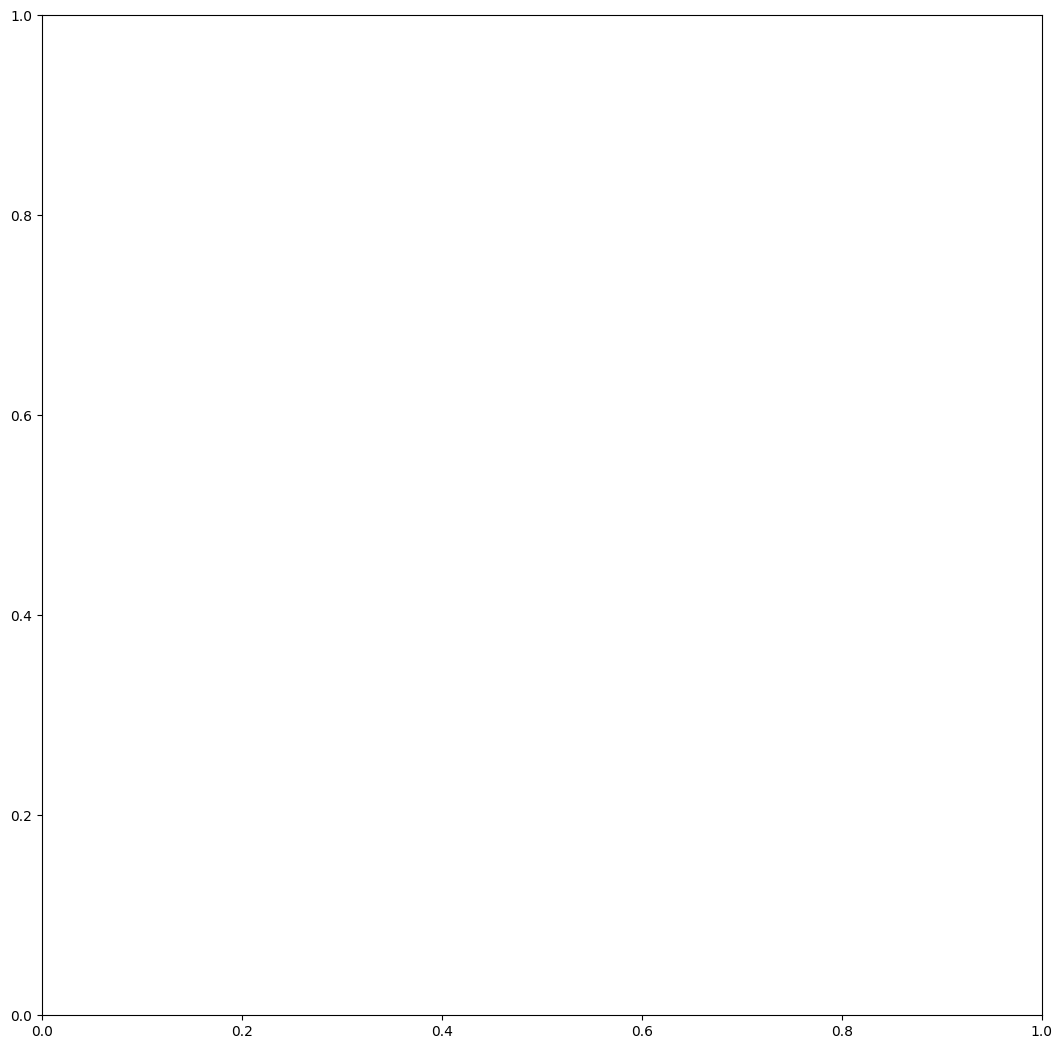

In [ ]:
import matplotlib.pyplot as plt
import random

# 임계값 설정 (예: 0.8 이상인 경우 엣지 생성)
threshold = 0.6
edges = np.argwhere(similarity > threshold)
edges = [(i, j) for i, j in edges if i != j]
import networkx as nx

# 그래프 생성
G = nx.Graph()

# 노드 추가
for idx, row in data.iterrows():
  perfume_name = row['Perfume']
  brand_name = row['Brand']
  G.add_node(perfume_name, **row.to_dict())  # 데이터프레임 행을 노드 속성으로 추가

# 엣지 추가
G.add_edges_from(edges)

#random_nodes = random.sample(list(G.nodes), 50)

# 선택된 노드들로 서브그래프 생성

#H = G.subgraph(random_nodes)

# 서브그래프 시각화
'''
plt.figure(figsize=(10, 10))
nx.draw(G, with_labels=True, node_size=500, node_color='skyblue', font_size=10, font_weight='bold', edge_color='black')
plt.title("Random Subgraph Visualization (50 Nodes)", fontsize=15)
plt.show()
'''

## 그래프 시각화

In [ ]:
!pip install pyvis

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 36.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 63.2 MB/s eta 0:00:00


In [ ]:
from pyvis.network import Network

# Pyvis 네트워크 객체 생성
net = Network(notebook=True, height="800px", width="100%", bgcolor="#222222", font_color="white")

# 노드와 엣지 추가
for node, attr in G.nodes(data=True):
    net.add_node(node, label=node, title=str(attr))

for source, target, weight in edges:
    net.add_edge(source, target, value=weight)

# 그래프 저장 및 시각화
net.show("graph.html")


AssertionError: 